In [46]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
import torch
import pandas as pd
import matplotlib.pyplot as plt
import os, sys

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load Data

In [48]:
!ls beliefbank_data/silver_sentences.csv

beliefbank_data/silver_sentences.csv


In [49]:
df = pd.read_csv("beliefbank_data/silver_sentences.csv", header=None)
df

,0
0,A american bison is a mammal.
1,A american bison is a american bison.
2,A american bison is an animal.
3,A american bison is a vertebrate.
4,A american bison is a warm blooded animal.
...,...
12631,A peony is not a building.
12632,A peony is not a salad.
12633,A peony is not a soda.
12634,A peony is not a toy.


# Load NLI model

In [50]:
### New NLI Model
max_length = 256

# nli_tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-mini-mnli")
# nli_model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-mini-mnli")

In [51]:
max_length = 256
nli_tokenizer = AutoTokenizer.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")
nli_model = AutoModelForSequenceClassification.from_pretrained("ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli")

Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Example NLI on pair of sentences

In [52]:
sent1 = df.iloc[0][0]
sent2 = df.iloc[1][0]
print(sent1)
print(sent2)

A american bison is a mammal.
A american bison is a american bison.


In [53]:
tokenized = nli_tokenizer.encode_plus(sent1, sent2, 
                                  max_length=max_length, 
                                  return_token_type_ids=True, 
                                  truncation=True)

In [54]:
input_ids = torch.Tensor(tokenized['input_ids']).long().unsqueeze(0)
token_type_ids = torch.Tensor(tokenized['token_type_ids']).long().unsqueeze(0)
attention_mask = torch.Tensor(tokenized['attention_mask']).long().unsqueeze(0)

In [55]:
nli_outputs = nli_model(input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=None)
nli_outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 2.8142,  0.5934, -3.2098]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [56]:
predicted_probability = torch.softmax(nli_outputs.logits, dim=1)[0].tolist()

In [57]:
print("Entailment:", predicted_probability[0])
print("Neutral:", predicted_probability[1])
print("Contradiction:", predicted_probability[2])

Entailment: 0.9001361131668091
Neutral: 0.09768557548522949
Contradiction: 0.0021782962139695883


In [58]:
def example_pair(sent1, sent2, nli_tokenizer, nli_model):
    tokenized = nli_tokenizer.encode_plus(sent1, sent2, 
                                  max_length=max_length, 
                                  return_token_type_ids=True, 
                                  truncation=True)
    
    input_ids = torch.Tensor(tokenized['input_ids']).to(device).long().unsqueeze(0)
    token_type_ids = torch.Tensor(tokenized['token_type_ids']).to(device).long().unsqueeze(0)
    attention_mask = torch.Tensor(tokenized['attention_mask']).to(device).long().unsqueeze(0)
    
    nli_outputs = nli_model(input_ids,
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        labels=None)
    predicted_probability = torch.softmax(nli_outputs.logits, dim=1)
    return predicted_probability

In [60]:
prob1 = example_pair(sent1, sent2, nli_tokenizer, nli_model)[0].tolist()
print("Entailment:", prob1[0])
print("Neutral:", prob1[1])
print("Contradiction:", prob1[2])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

In [61]:
prob2 = example_pair(sent2, sent1, nli_tokenizer, nli_model)[0].tolist()
print("Entailment:", prob2[0])
print("Neutral:", prob2[1])
print("Contradiction:", prob2[2])

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

# Example NLI on a batch

In [62]:
sents = df.iloc[0:10][0].tolist()
sents

['A american bison is a mammal.',
 'A american bison is a american bison.',
 'A american bison is an animal.',
 'A american bison is a vertebrate.',
 'A american bison is a warm blooded animal.',
 'A american bison is able to drink liquids.',
 'A american bison has a hair.',
 'A american bison is a air breathing vertebrate.',
 'A american bison is able to mate.',
 'A american bison is a amniote.']

In [63]:
def example_batch(sents, nli_tokenizer, nli_model):
    B = len(sents)
    prem = []
    hypo = []
    for i1 in range(B):
        for i2 in range(B):
            prem.append(sents[i1])
            hypo.append(sents[i2])

    tokenized = nli_tokenizer(prem, hypo, 
                              max_length=max_length, 
                              return_token_type_ids=True, 
                              truncation=True,
                              padding=True)
    
    input_ids = torch.Tensor(tokenized['input_ids']).to(device).long()
    token_type_ids = torch.Tensor(tokenized['token_type_ids']).to(device).long()
    attention_mask = torch.Tensor(tokenized['attention_mask']).to(device).long()
    
    nli_outputs = nli_model(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=None)
    predicted_probability = torch.softmax(nli_outputs.logits, dim=1)
    contra_matrix = predicted_probability[..., 2]
    contra_matrix = contra_matrix.reshape(B, B)
    return contra_matrix

In [64]:
contra_matrix = example_batch(sents, nli_tokenizer, nli_model)
contra_matrix = contra_matrix.detach().cpu().numpy()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper__index_select)

NameError: name 'contra_matrix' is not defined

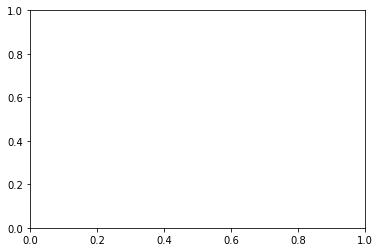

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(contra_matrix)
fig.colorbar(cax)

ax.set_yticks(range(len(sents)))
ax.set_yticklabels(sents)
ax.set_xticks(range(len(sents)))
# ax.set_yticklabels(sents)

plt.show()